In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sqlalchemy import create_engine
import seaborn as sns
from scipy.stats import boxcox
from scipy import stats
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold


import warnings
warnings.filterwarnings('ignore')

In [223]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()


In [224]:
clean_df = df.copy()
clean_df.alley.unique()
clean_df.alley.fillna('None', inplace=True)
clean_df.lotfrontage.fillna(0, inplace=True)

In [225]:
clean_df.masvnrtype.fillna('None', inplace=True)
clean_df.masvnrarea.fillna(0.0, inplace=True)
clean_df.bsmtqual.fillna('NA', inplace=True)
clean_df.bsmtcond.fillna('NA', inplace=True)
clean_df.bsmtexposure.fillna('NA', inplace=True)
clean_df.bsmtfintype1.fillna('NA', inplace=True)
clean_df.bsmtfintype2.fillna('NA', inplace=True)
clean_df.bsmtexposure.fillna('NA', inplace=True)
clean_df.electrical.fillna('SBrkr', inplace=True)
clean_df.fireplacequ.fillna('NA', inplace=True)
clean_df.garagetype.fillna('NA', inplace=True)
clean_df.garageyrblt.fillna('NA', inplace=True)
clean_df.garagefinish.fillna('NA', inplace=True)
clean_df.garagequal.fillna('NA', inplace=True)
clean_df.garagecond.fillna('NA', inplace=True)
clean_df.poolqc.fillna('NA', inplace=True)
clean_df.fence.fillna('NA', inplace=True)
clean_df.miscfeature.fillna('NA', inplace=True)

In [226]:
feature_df = clean_df[['lotarea', 'overallqual']].copy()

In [227]:
bldgtype_list = []
for i in df.bldgtype:
    if i == '2fmCon':
        bldgtype_list.append('Duplex')
    else:
        bldgtype_list.append(i)
clean_df['bldgtype'] = bldgtype_list
x = pd.get_dummies(clean_df.bldgtype, drop_first=True).copy()
for i in range(len(clean_df.bldgtype.unique()) - 1):
    feature_df['bldgtype' + clean_df.bldgtype.unique()[i + 1]] = x.iloc[:,i]

In [228]:
keywords = ['garagequal', 'kitchenqual', 'bsmtcond', 'bsmtqual', 'exterqual' ]
for word in keywords:
    nums = []
    for row in clean_df[word]:
        if row == 'Fa':
            nums.append(1)
        elif row == 'TA':
            nums.append(2)
        elif row == 'Gd':
            nums.append(3)
        elif row == 'Ex':
            nums.append(4)
        else:
            nums.append(0)
    feature_df[word] = nums
    

In [229]:
feature_df[['garagecars', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd', 'fireplaces', 'bsmtfinsf1', 'wooddecksf', 'secondflrsf']] = clean_df[['garagecars', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd', 'fireplaces', 'bsmtfinsf1', 'wooddecksf', 'secondflrsf']]

In [230]:
feature_df['isWDsale'] = x.iloc[:,-1]

In [231]:
feature_df['logsaleprice'] = winsorize(np.log(clean_df.saleprice), (0.01, 0.02))

In [232]:
Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     435.7
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:15:24   Log-Likelihood:                 757.85
No. Observations:                1460   AIC:                            -1474.
Df Residuals:                    1439   BIC:                            -1363.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.0320      0.580      6.949      0.000       2.894       5.170
lotarea         1.951e-06   4.21e-07      4.635      0.000    1.13e-06    2.78e-06
overallqual        0.0725      0.005     13.903      0.000       0.062       0.083
bldgtypeDuplex    -0.0415      0.019     -2.243      0.025      -0.078      -0.005
bldgtypeTwnhsE    -0.1675      0.024     -7.106      0.000      -0.214      -0.121
bldgtypeTwnhs     -0.0421      0.008     -5.348      0.000      -0.057      -0.027
garagequal         0.0354      0.009      3.760      0.000       0.017       0.054
kitchenqual        0.0402      0.009      4.352      0.000       0.022       0.058
bsmtcond           0.0529      0.011      4.882      0.000       0.032       0.074
bsmtqual           0.0208      0.009      2.409      0.016       0.004       0.038
exterqual          0.0243      0.011      2.143      0.032       0.002       0.047
garagecars         0.0522      0.008      6.416      0.000       0.036       0.068
firstflrsf         0.0002   1.95e-05      9.447      0.000       0.000       0.000
fullbath           0.0195      0.011      1.847      0.065      -0.001       0.040
totrmsabvgrd       0.0118      0.004      2.623      0.009       0.003       0.021
yearbuilt          0.0016      0.000      7.429      0.000       0.001       0.002
yearremodadd       0.0018      0.000      6.720      0.000       0.001       0.002
fireplaces         0.0560      0.007      7.791      0.000       0.042       0.070
bsmtfinsf1      6.204e-05   1.01e-05      6.140      0.000    4.22e-05    8.19e-05
wooddecksf         0.0001   3.26e-05      3.551      0.000    5.18e-05       0.000
secondflrsf        0.0001   1.69e-05      7.899      0.000       0.000       0.000
isWDsale          -0.0421      0.008     -5.348      0.000      -0.057      -0.027
==============================================================================
Omnibus:                     1023.984   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53517.484
Skew:                          -2.660   Prob(JB):                         0.00
Kurtosis:                      32.179   Cond. No.                     3.02e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.44e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [233]:
Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state = 21)

X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     359.6
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:15:24   Log-Likelihood:                 623.69
No. Observations:                1168   AIC:                            -1205.
Df Residuals:                    1147   BIC:                            -1099.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.2698      0.649      6.581      0.000       2.997       5.543
lotarea         2.019e-06   4.73e-07      4.269      0.000    1.09e-06    2.95e-06
overallqual        0.0693      0.006     12.006      0.000       0.058       0.081
bldgtypeDuplex    -0.0373      0.020     -1.884      0.060      -0.076       0.002
bldgtypeTwnhsE    -0.1700      0.026     -6.565      0.000      -0.221      -0.119
bldgtypeTwnhs     -0.0428      0.009     -4.837      0.000      -0.060      -0.025
garagequal         0.0431      0.010      4.136      0.000       0.023       0.063
kitchenqual        0.0430      0.010      4.117      0.000       0.023       0.064
bsmtcond           0.0540      0.012      4.533      0.000       0.031       0.077
bsmtqual           0.0240      0.010      2.486      0.013       0.005       0.043
exterqual          0.0271      0.013      2.161      0.031       0.003       0.052
garagecars         0.0487      0.009      5.531      0.000       0.031       0.066
firstflrsf         0.0002   2.19e-05      9.146      0.000       0.000       0.000
fullbath           0.0234      0.012      1.982      0.048       0.000       0.046
totrmsabvgrd       0.0093      0.005      1.876      0.061      -0.000       0.019
yearbuilt          0.0015      0.000      6.651      0.000       0.001       0.002
yearremodadd       0.0017      0.000      5.811      0.000       0.001       0.002
fireplaces         0.0494      0.008      6.220      0.000       0.034       0.065
bsmtfinsf1      6.216e-05   1.11e-05      5.604      0.000    4.04e-05    8.39e-05
wooddecksf         0.0001   3.57e-05      3.369      0.001    5.03e-05       0.000
secondflrsf        0.0002   1.88e-05      8.156      0.000       0.000       0.000
isWDsale          -0.0428      0.009     -4.837      0.000      -0.060      -0.025
==============================================================================
Omnibus:                      901.782   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62920.666
Skew:                          -2.958   Prob(JB):                         0.00
Kurtosis:                      38.467   Cond. No.                     2.74e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.31e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

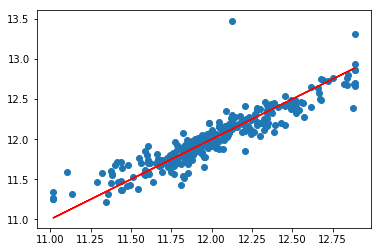

Mean absolute error of the prediction is: 0.10265506684939711
Mean squared error of the prediction is: 0.023468093494515903
Root mean squared error of the prediction is: 0.1531929942736152
Mean absolute percentage error of the prediction is: 0.8569558463880806


In [234]:
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [235]:
lassoregr = Lasso(alpha=.01) 
lassoregr.fit(X_train, y_train)

y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
# Makes my model worse for every alpha

R-squared of the model on the training set is: 0.8423058823713512
-----Test set statistics-----
R-squared of the model on the test set is: 0.8219998824656616
Mean absolute error of the prediction is: 0.10606371189993687
Mean squared error of the prediction is: 0.025998509738441176
Root mean squared error of the prediction is: 0.16124053379482833
Mean absolute percentage error of the prediction is: 0.8848469754314078


In [236]:
elasticregr = ElasticNet(alpha=.1, l1_ratio=.01) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8553891186418746
-----Test set statistics-----
R-squared of the model on the test set is: 0.8318660861715274
Mean absolute error of the prediction is: 0.10370347932649873
Mean squared error of the prediction is: 0.024557462413970083
Root mean squared error of the prediction is: 0.1567082078704561
Mean absolute percentage error of the prediction is: 0.865549800472665


In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state = 1)
    
ridgeregr = Ridge(alpha=5) 
ridgeregr.fit(X_train, y_train)
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.851274334031348
-----Test set statistics-----
R-squared of the model on the test set is: 0.8829156804720802
Mean absolute error of the prediction is: 0.09547733193900931
Mean squared error of the prediction is: 0.017563625788247477
Root mean squared error of the prediction is: 0.13252783024047243
Mean absolute percentage error of the prediction is: 0.7997680335018409


In [238]:
kfolds = 30
sumscores = 0
for i in range(kfolds):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.15, random_state = i)
    
    ridgeregr = Ridge(alpha=20) 
    ridgeregr.fit(X_train, y_train)
    y_preds_train = ridgeregr.predict(X_train)
    y_preds_test = ridgeregr.predict(X_test)
    
    sumscores += ridgeregr.score(X_test, y_test)
print(sumscores/kfolds)

0.8437014884594604


In [239]:
# My little homemade kfold...Hope this is good.

In [240]:
clean_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


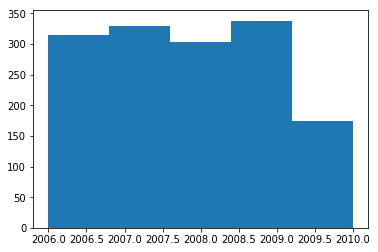

In [246]:
plt.hist(clean_df.yrsold, bins=5)
plt.show()

In [249]:
# Freddie Mac, 30-Year Fixed Rate Mortgage Average in the United States [MORTGAGE30US], 
# retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MORTGAGE30US, 
# September 11, 2019.
mortgage_df = pd.read_csv('/Users/jdobrow/Desktop/Programming Files/MORTGAGE30US.csv')

In [253]:
mortgage_df.head()

,DATE,MORTGAGE30US
0,1971-04-02,7.33
1,1971-04-09,7.31
2,1971-04-16,7.31
3,1971-04-23,7.31
4,1971-04-30,7.29


In [257]:
mortgage_df.DATE[0].split('-')

['1971', '04', '02']

In [260]:
month=[]
for i in range(len(mortgage_df)):
    month.append(int(mortgage_df.DATE[i].split('-')[1]))
mortgage_df['Month'] = month

In [263]:
year=[]
for i in range(len(mortgage_df)):
    year.append(int(mortgage_df.DATE[i].split('-')[0]))
mortgage_df['Year'] = year

In [265]:
mortgage_df.head()

,DATE,MORTGAGE30US,Month,Year
0,1971-04-02,7.33,4,1971
1,1971-04-09,7.31,4,1971
2,1971-04-16,7.31,4,1971
3,1971-04-23,7.31,4,1971
4,1971-04-30,7.29,4,1971


In [278]:
year_month_avg = []
for year in mortgage_df.Year.unique():
    for month in mortgage_df.Month.unique():
        total = 0
        count = 0
        for i in mortgage_df.MORTGAGE30US[(mortgage_df.Year == year) & (mortgage_df.Month == month)]:
            total += i
            count += 1
        for i in range(count):
            year_month_avg.append(total/count)
mortgage_df['AvgMortgage'] = year_month_avg

In [281]:
clean_mortgage_df = mortgage_df.copy()
clean_mortgage_df.drop(['MORTGAGE30US', 'DATE'], axis=1, inplace=True)

In [283]:
clean_mortgage_df.head()

,Month,Year,AvgMortgage
0,4,1971,7.31
1,4,1971,7.31
2,4,1971,7.31
3,4,1971,7.31
4,4,1971,7.31


In [285]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [294]:
avg_mortgage_list = []
for i in range(len(df)):
    month = df.mosold[i]
    year = df.yrsold[i]
    avg_mortgage_list.append(clean_mortgage_df.AvgMortgage[(clean_mortgage_df.Month == month) & (clean_mortgage_df.Year == year)].iloc[0])
feature_df['AvgMortgageUS'] = avg_mortgage_list

In [296]:
feature_df.drop('logsaleprice', axis=1, inplace=True)
feature_df['logsaleprice'] = winsorize(np.log(clean_df.saleprice), (0.01, 0.02))
feature_df.head()

,lotarea,overallqual,bldgtypeDuplex,bldgtypeTwnhsE,bldgtypeTwnhs,garagequal,kitchenqual,bsmtcond,bsmtqual,exterqual,...,totrmsabvgrd,yearbuilt,yearremodadd,fireplaces,bsmtfinsf1,wooddecksf,secondflrsf,isWDsale,AvgMortgageUS,logsaleprice
0,8450,7,0,0,0,2,3,2,3,3,...,8,2003,2003,0,706,0,854,0,6.0360,12.247694
1,9600,6,0,0,0,2,2,2,3,2,...,6,1976,1976,1,978,298,0,0,6.5720,12.109011
2,11250,7,0,0,0,2,3,2,3,3,...,6,2001,2002,1,486,0,866,0,5.2860,12.317167
3,9550,7,0,0,0,2,3,3,2,2,...,7,1915,1970,1,216,0,756,0,6.5975,11.849398
4,14260,8,0,0,0,2,3,2,3,3,...,9,2000,2000,1,655,192,1053,0,5.9175,12.429216


In [301]:
Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state = 1)
    
ridgeregr = Ridge(alpha=5) 
ridgeregr.fit(X_train, y_train)
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8515865454836766
-----Test set statistics-----
R-squared of the model on the test set is: 0.8832546792176765
Mean absolute error of the prediction is: 0.09538971639255514
Mean squared error of the prediction is: 0.01751277314517501
Root mean squared error of the prediction is: 0.13233583469784369
Mean absolute percentage error of the prediction is: 0.7990164538234013


In [ ]:
# I added data about mean mortgage prices across the US into the model. The model determines the year and month
# that the house was sold and references it against the average US price. This external data is just one variable
# amongst many but actually very slightly improved the R^2. Using data from seperate sources is a little weird
# and could result in some more uncertainty with the consistancy of data collection.